In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [32]:
dataset = pd.read_csv("powerconsumption.csv")
dataset.head() #Show the first lines of the dataframe

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964

In [33]:
power = np.array(dataset['PowerConsumption_Zone1'])
power

array([34055.6962 , 29814.68354, 29128.10127, ..., 29590.87452,
       28958.1749 , 28349.80989])

In [34]:
def format_dataset(s: np.ndarray, n: int):
    """
    Returns (X,Y).
    
    params:
        s (ndarray) - 1D NumPy array containing the time series;
        n (int) - size of each row in the X matrix.
    """
    assert s.ndim == 1
    assert s.shape[0] >= n+1
    
    X = np.expand_dims(s[0:n], axis=0) #initialize X as [[s_1,...,s_n]]
    Y = np.array([s[n]]) #initialize Y as [s_{n+1}]
    
    L = s.shape[0]
    for i in range(1, L):
        if i+n >= L: break
        X = np.vstack([X, s[i:n+i]]) #Append a row [s_i,...,s_{n+i}] to X
        Y = np.append(Y, s[n+i]) #Append s_[n+i+1] to Y
        
    return X, Y

In [35]:
class AutoRegressive():
    def __init__(self, n: int):
        """
        params:
            n (int) - amount of samples [x_{i-n},...,x_{i-1}] used to predict x_i.
        """
        assert n >= 1
        self.n = n
        self.f = linear_model.LinearRegression()
    
    def fit(self, s: np.ndarray):
        """
        params:
            s (ndarray) - 1D NumPy array containing the time series;
        """
        assert s.ndim == 1
        assert s.shape[0] >= self.n+1
        X, Y = format_dataset(s, self.n)
        self.f.fit(X,Y)
    
    def forecast(self, base: np.ndarray, w: int = 1):
        """
        params:
            base (ndarray) - 1D NumPy array containing the n past samples required to predict the next w samples;
            w (int) - amount of samples to forecast.
        """
        assert base.ndim == 1
        assert base.shape[0] == self.n
        
        #this is an alternative implementation of the recursive function g(chi,i)
        forecast = np.zeros((w,))
        for i in range(w):
            x = np.append(base[i:], forecast[:i])
            forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
        return forecast

In [36]:
def validate(model: AutoRegressive, series: np.ndarray):
    """
    Return the average R^2 score of the forecasts assuming n=w.
    """
    assert series.ndim == 1
    assert series.shape[0]//model.n >= 2
    slices = [series[i*model.n:(i+1)*model.n] for i in range(series.shape[0]//model.n)]
    
    mean_r2 = 0
    for i in range(len(slices)-1):
        forecast = model.forecast(slices[i], model.n)
        mean_r2 += r2_score(forecast, slices[i+1])/(len(slices)-1)
    
    return mean_r2

In [37]:
folds = [power[i*(power.shape[0]//4):(i+1)*(power.shape[0]//4)] for i in range(4)]
models = []

for i in range(3):
    print(f'--- Training with the {i}th fold and validating with the {i+1}th fold ---')
    training, validation = folds[i], folds[i+1]
    model = AutoRegressive(24*6)
    model.fit(training)
    mean_r2 = validate(model, validation)
    print('Average R2-score:', round(mean_r2, 4))
    models.append(model)

--- Training with the 0th fold and validating with the 1th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

Average R2-score: 0.8878
--- Training with the 2th fold and validating with the 3th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

--- Training with the 0th fold and validating with the 1th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

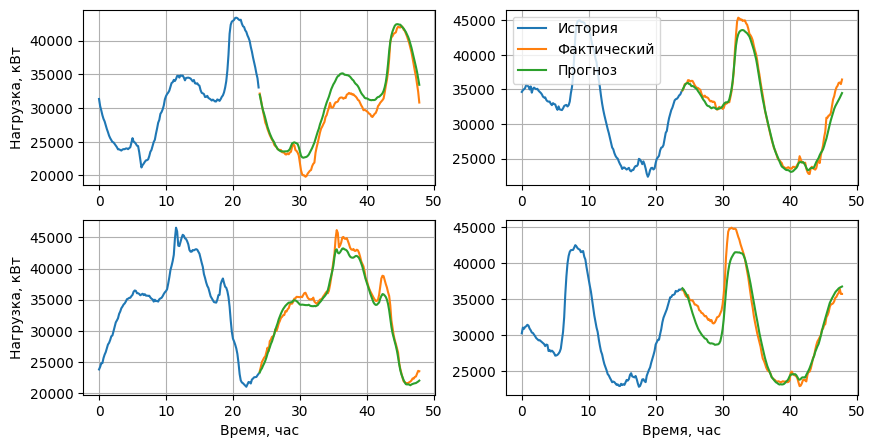

--- Training with the 1th fold and validating with the 2th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

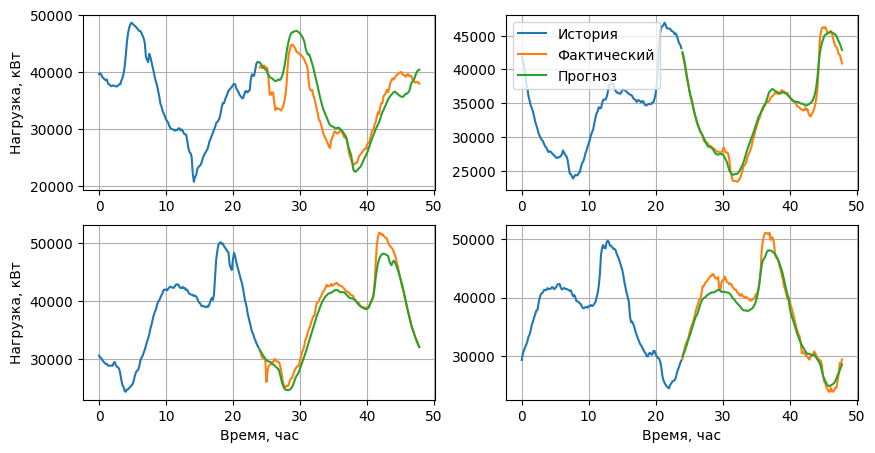

--- Training with the 2th fold and validating with the 3th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

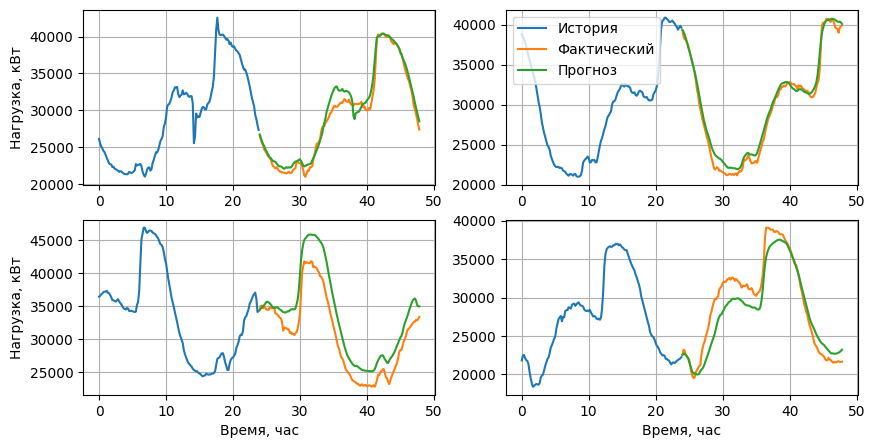

In [43]:
for i in range(3):
    print(f'--- Training with the {i}th fold and validating with the {i+1}th fold ---')
    
    training, validation = folds[i], folds[i+1]
    model = models[i]
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 2.5*2))

    row_index, col_index = 0, 0
    for row in ax:
        col_index = 0
        for col in row:
            k = np.random.randint(0, validation.shape[0]-2*24*6)
            
            base_slice = np.arange(0,24*6)/6, validation[k: k+24*6]
            actual_slice = np.arange(24*6,2*24*6)/6, validation[k+24*6: k+2*24*6]
            predicted_slice = np.arange(24*6,2*24*6)/6, model.forecast(base_slice[1], 24*6)
            
            col.plot(base_slice[0], base_slice[1], label='История')
            col.plot(actual_slice[0], actual_slice[1], label='Фактический')
            col.plot(predicted_slice[0], predicted_slice[1], label='Прогноз')
            col.grid()
            
            if row_index == 1: col.set_xlabel('Время, час')
            if col_index == 0: col.set_ylabel('Нагрузка, кВт')
            if (row_index, col_index) == (0, 1): col.legend()
                
            col_index += 1
        row_index += 1

    plt.show()

In [ ]:
https://www.kaggle.com/code/filipechagas/electric-power-consumption-forecasting-ar/notebook

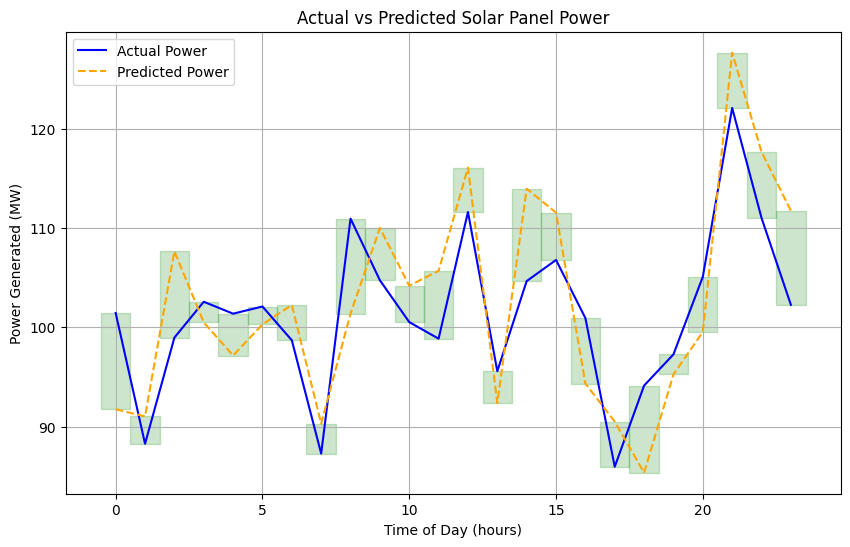

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
hours = np.arange(0, 24)
actual_power = np.random.normal(100, 10, size=24)  # Sample actual power data
predicted_power = actual_power * np.random.uniform(0.9, 1.1, size=24)  # Sample predicted power data with 90% accuracy

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(hours, actual_power, label='Actual Power', color='blue')
plt.plot(hours, predicted_power, label='Predicted Power', color='orange', linestyle='--')
plt.xlabel('Time of Day (hours)')
plt.ylabel('Power Generated (MW)')
plt.title('Actual vs Predicted Solar Panel Power')
plt.legend()

# Shade the region where actual and predicted values match
for hour, actual, predicted in zip(hours, actual_power, predicted_power):
    if abs(actual - predicted) / actual <= 0.1:  # If the prediction is within 10% of actual
        plt.fill_between([hour - 0.5, hour + 0.5], actual, predicted, color='green', alpha=0.2)

plt.grid(True)
plt.show()


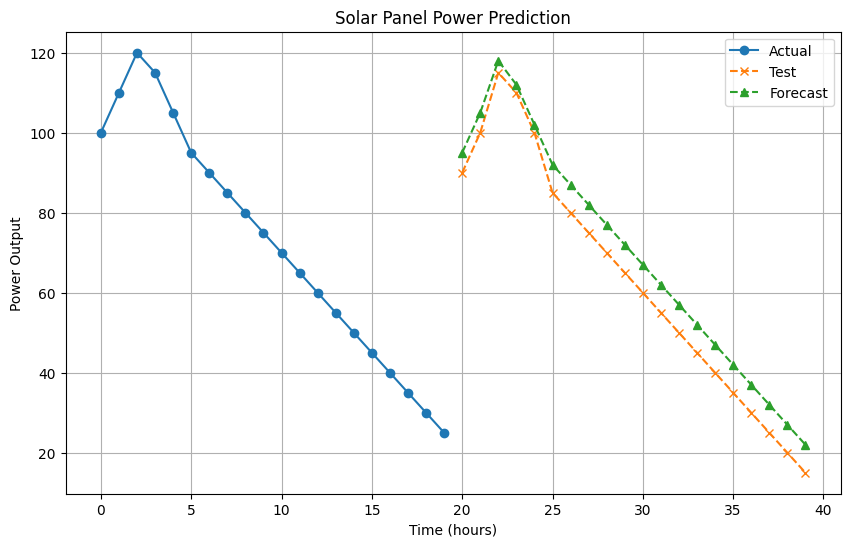

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data (replace with your actual data)
actual_data = pd.Series([100, 110, 120, 115, 105, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25])
test_data = pd.Series([90, 100, 115, 110, 100, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15])
predicted_data = pd.Series([95, 105, 118, 112, 102, 92, 87, 82, 77, 72, 67, 62, 57, 52, 47, 42, 37, 32, 27, 22])

# Plotting
plt.figure(figsize=(10, 6))

# Plot actual data for the first 20 hours
plt.plot(range(20), actual_data, label='Actual', marker='o')

# Plot test data from 20 to 40 hours
plt.plot(range(20, 40), test_data, label='Test', linestyle='--', marker='x')

# Plot forecast data from 20 to 40 hours
plt.plot(range(20, 40), predicted_data, label='Forecast', linestyle='--', marker='^')

plt.title('Solar Panel Power Prediction')
plt.xlabel('Time (hours)')
plt.ylabel('Power Output')
plt.legend()
plt.grid(True)
plt.show()


--- Training with the 0th fold and validating with the 1th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

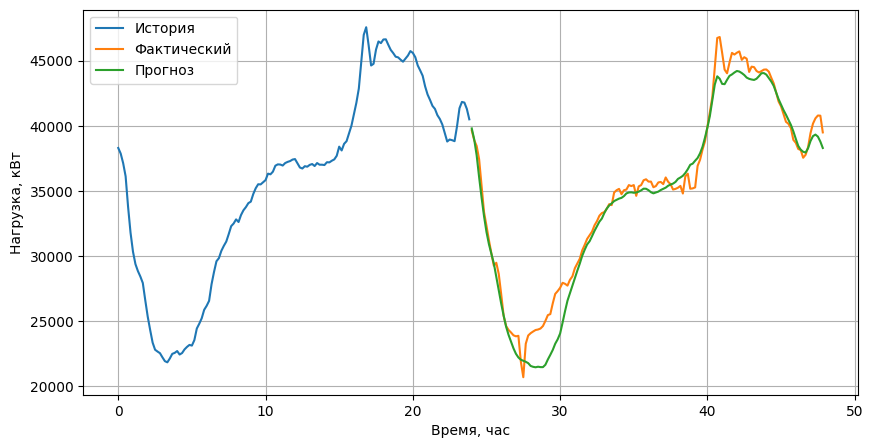

C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

--- Training with the 1th fold and validating with the 2th fold ---


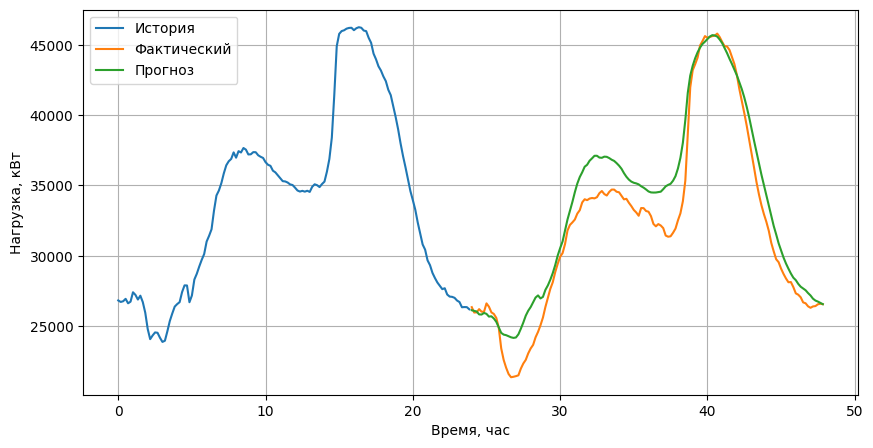

--- Training with the 2th fold and validating with the 3th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

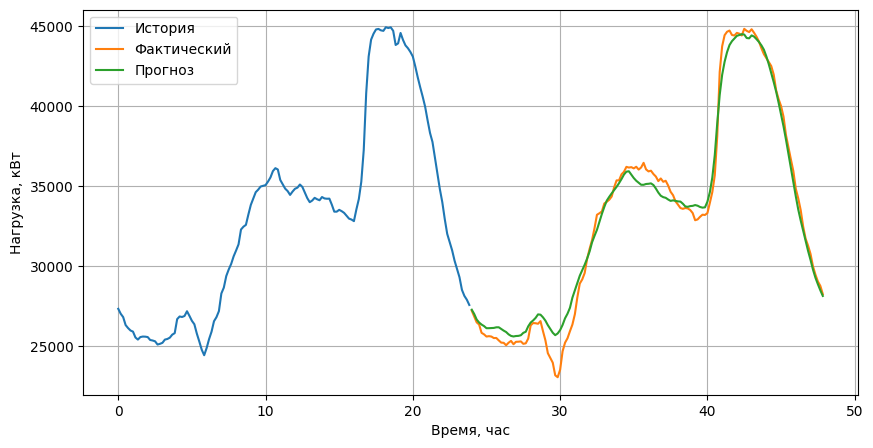

In [39]:
for i in range(3):
    print(f'--- Training with the {i}th fold and validating with the {i+1}th fold ---')
    
    training, validation = folds[i], folds[i+1]
    model = models[i]

    fig, ax = plt.subplots(figsize=(10, 5))  # Define a single plot
    
    k = np.random.randint(0, validation.shape[0]-2*24*6)
    
    base_slice = np.arange(0,24*6)/6, validation[k: k+24*6]
    actual_slice = np.arange(24*6,2*24*6)/6, validation[k+24*6: k+2*24*6]
    predicted_slice = np.arange(24*6,2*24*6)/6, model.forecast(base_slice[1], 24*6)
    
    ax.plot(base_slice[0], base_slice[1], label='История')
    ax.plot(actual_slice[0], actual_slice[1], label='Фактический')
    ax.plot(predicted_slice[0], predicted_slice[1], label='Прогноз')
    ax.grid()
    ax.set_xlabel('Время, час')
    ax.set_ylabel('Нагрузка, кВт')
    ax.legend()
    
    plt.show()


--- Training with the 0th fold and validating with the 1th fold ---


C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  forecast[i] = self.f.predict(np.expand_dims(x, axis=0))
C:\Users\Umarov.Sh\AppData\Local\Temp\ipykernel_9468\1419421327.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  foreca

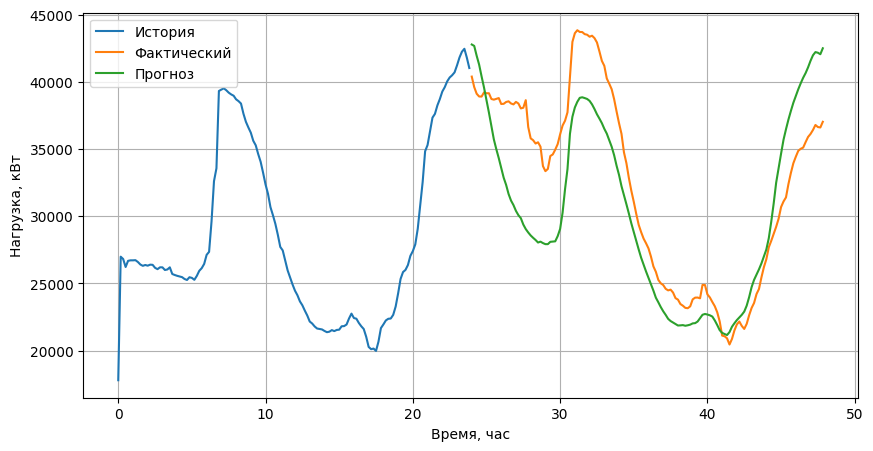

In [40]:
i = 0  # Select the desired iteration
print(f'--- Training with the {i}th fold and validating with the {i+1}th fold ---')

training, validation = folds[i], folds[i+1]
model = models[i]

fig, ax = plt.subplots(figsize=(10, 5))

k = np.random.randint(0, validation.shape[0]-2*24*6)

base_slice = np.arange(0,24*6)/6, validation[k: k+24*6]
actual_slice = np.arange(24*6,2*24*6)/6, validation[k+24*6: k+2*24*6]
predicted_slice = np.arange(24*6,2*24*6)/6, model.forecast(base_slice[1], 24*6)

ax.plot(base_slice[0], base_slice[1], label='История')
ax.plot(actual_slice[0], actual_slice[1], label='Фактический')
ax.plot(predicted_slice[0], predicted_slice[1], label='Прогноз')
ax.grid()
ax.set_xlabel('Время, час')
ax.set_ylabel('Нагрузка, кВт')
ax.legend()

plt.show()
